In [12]:
# ADJUST THIS FOR YOUR MACHINE
output_directory_path = "results"  # Directory where the results are stored
plot_directory_path = "plots"  # Directory for saving plots

In [13]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import tqdm
import pathlib

matplotlib.rcParams.update({"font.size": 6})
plt.rcParams.update({"font.sans-serif": "Arial"})

In [14]:
plots_dir = pathlib.Path(plot_directory_path)
plots_dir.mkdir(exist_ok=True)  # Create the directory if it does not exist

In [15]:
# Load paths to all experiment folders
path_dir = pathlib.Path(output_directory_path)
yml_paths = [
    path.with_suffix(".yml")
    for path in path_dir.glob("*")
    if path.is_file()
]

In [16]:
# Load paths to all experiment folders
paths_dir = [pathlib.Path("../NeMAAP/experiments/0830"), pathlib.Path("../NeMAAP/experiments/0815")]
yml_paths = [
    path
    for path_dir in paths_dir
    for path in path_dir.glob("*")
    if path.is_file() and path.suffix == ".yml"
]

In [17]:
RESULTS = {}

for i, yml_path in tqdm.tqdm(enumerate(yml_paths), total=len(yml_paths)):

    # Path to .csv file with phenotypes
    path = yml_path.with_suffix("") / "0/visor/phenotypes.csv"
    phenokind, popsize, reprmode, i = yml_path.stem.split("-")

    pheno = pd.read_csv(path, usecols=range(50))
    pheno = pheno.iloc[-1]

    # Save RESULTS
    RESULTS[(phenokind, popsize, reprmode, i)] = pheno

100%|██████████| 360/360 [00:26<00:00, 13.78it/s]


# Plotting

In [18]:
# PLOTTING SETUP

format_ = "png"
savefig_settings = {"dpi": 300}
matplotlib.rcParams.update({"font.size": 8})

# Transform data into a table
df = pd.DataFrame(RESULTS).T.sort_index().droplevel(3, axis=0)
n_specs_studied = int(len(df) / len(df.index.unique()))

figsize = (2, 2)
dpi = 300

colors = ["crimson", "forestgreen", "dodgerblue"]
plot_colors = [color for color in colors for _ in range(n_specs_studied)]

patches = [
    mpatches.Circle(xy=(0, 0), color=colors[0], label="300"),
    mpatches.Circle(xy=(0, 0), color=colors[1], label="3000"),
    mpatches.Circle(xy=(0, 0), color=colors[2], label="30000"),
]

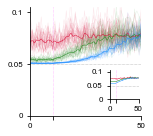

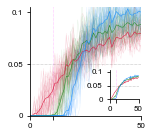

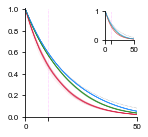

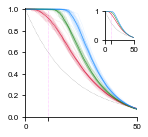

In [19]:
# Plot figure 2 and figure 3

ax_set_styles_general = dict(
    xlim=[0, 49],
    xticks=[0, 10, 49],
    xticklabels=[0, "", 50],
    facecolor="white",
)

ax_set_styles_mort = dict(
    ylim=[0, 0.105],
    yticks=[0, 0.05, 0.1],
    yticklabels=[0, 0.05, 0.1],
)

ax_set_styles_surv = dict(
    ylim=[0, 1.01],
)



def plot_lh(df, aging_theory, repr_mode, ax, lw, plot_bckg=False, plot_surv=False):

    global data

    # plot lines
    ax.vlines(10, 0, 1, color="magenta", ls="dotted", alpha=0.5, lw=lw)
    if plot_surv:
        default_survivorship = 0.95 ** np.arange(51)
        ax.plot(default_survivorship, color="gray", ls="dotted", lw=lw)
    else:
        ax.hlines(0.05, 0, 51, color="gray", ls="dotted", lw=0.5)

    # calculate data to plot
    if plot_surv:
        data = df.cumprod(1).loc[aging_theory, :, repr_mode].copy()
        data.insert(0, "newcol", [1] * len(data), allow_duplicates=True)
        data = data.T.reset_index(drop=True).T
    else:
        data = (1 - df).loc[aging_theory, :, repr_mode]

    # plot background curves
    if plot_bckg:
        data.T.plot(
            legend=False,
            color=plot_colors,
            ax=ax,
            alpha=0.1,
            lw=lw,
        )


    # plot mean curve
    data.reset_index().drop(["level_0", "level_2"], axis=1).groupby("level_1").mean(0).T.plot(
        ax=ax,
        color=colors,
        lw=lw,
    )

    ax_set_styles = ax_set_styles_surv if plot_surv else ax_set_styles_mort
    ax.set(**ax_set_styles_general, **ax_set_styles)
    ax.spines[["right", "top"]].set_visible(False)
    ax.get_legend().remove()


aging_theories = ["MA", "AP"]
for mortorsurv in ["mort", "surv"]:
    for aging_theory in aging_theories:
        fig, ax = plt.subplots(figsize=figsize, facecolor="white")

        # main plot
        plot_lh(
            df=df, aging_theory=aging_theory, repr_mode="sexual", ax=ax, lw=0.5, plot_bckg=True, plot_surv=mortorsurv == "surv",
        )

        # inset

        if mortorsurv == "surv":
            ax = fig.add_axes([0.68, 0.66, 0.2, 0.2])
        else:
            ax = fig.add_axes([0.68, 0.24, 0.2, 0.2])
        plot_lh(df=df, aging_theory=aging_theory, repr_mode="asexual_diploid", ax=ax, lw=0.5, plot_surv=mortorsurv == "surv")

        # save
        fig.savefig(
            plots_dir / f"{2 if aging_theory == 'MA' else 3}-{mortorsurv}-{aging_theory}.{format_}",
            bbox_inches="tight",
            **savefig_settings,
        )

        # # Plot only asexual
        # fig, ax = plt.subplots(figsize=figsize, facecolor="white")
        # plot_lh(
        #     df=df,
        #     aging_theory=aging_theory,
        #     repr_mode="asexual_diploid",
        #     ax=ax,
        #     lw=0.5,
        #     plot_bckg=True,
        #     plot_surv=mortorsurv == "surv",
        # )
        # fig.savefig(
        #     plots_dir / f"SUPP-{mortorsurv}-{aging_theory}-asex.{format_}",
        #     bbox_inches="tight",
        #     **savefig_settings,
        # )